# Total variation in-painting

## Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

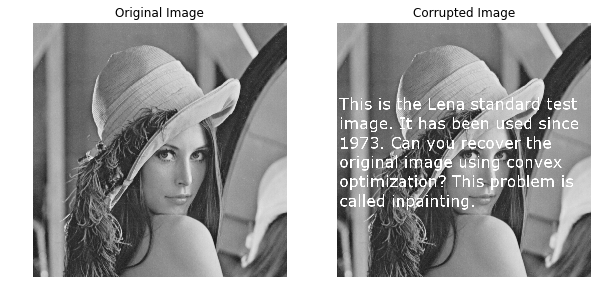

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
orig_img = Image.open("data/lena512.png")
corr_img = Image.open("data/lena512_corrupted.png")


# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)
rows, cols = Uorig.shape

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
Known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if Uorig[i, j] == Ucorr[i, j]:
            Known[i, j] = 1

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

The total variation in-painting problem can be easily expressed in CVXPY. We use the solver SCS, which finds the optimal value in a few seconds. The solvers ECOS and CVXOPT take much longer to solve this large problem.

In [2]:
# Recover the original image using total variation in-painting.
import cvxpy as cvx
U = cvx.Variable(shape=(rows, cols))
obj = cvx.Minimize(cvx.tv(U))
constraints = [cvx.multiply(Known, U) == cvx.multiply(Known, Ucorr)]
prob = cvx.Problem(obj, constraints)
# Use SCS to solve the problem.
prob.solve(verbose=True, solver=cvx.SCS)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1547594, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 523265, constraints m = 1045507
Cones:	primal zero / dual free vars: 262144
	soc vars: 783363, soc blks: 261121
Setup time: 1.97e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.33e+00  4.95e+00  1.00e+00 -1.49e+08  6.22e+06  3.51e-08  1.69e+00 
   100| 3.43e-03  1.35e-03  5.41e-03  2.16e+06  2.18e+06  4.13e-09  3.28e+01 
   200| 1.09e-03  2.52e-04  1.18e-03  2.20e+06  2.20e+06  4.25e-09  7.05e

2201748.401638712

After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.

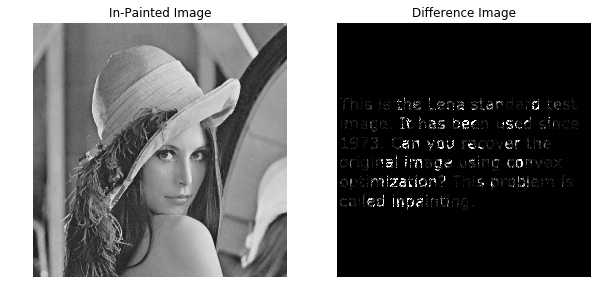

In [3]:
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(U.value)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(10*np.abs(Uorig - U.value))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');

# Color Images

For color images, the in-painting problem is similar to the grayscale case. A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.

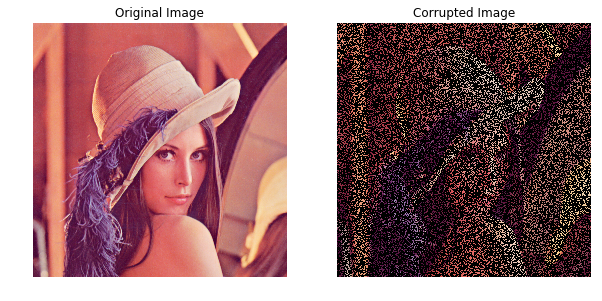

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
# Load the images.
orig_img = Image.open("data/lena512color.tiff")

# Convert to arrays.
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The Known matrix is initialized randomly.
Known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                Known[i, j, k] = 1
            
Ucorr = Known*Uorig
corr_img = Image.fromarray(np.uint8(Ucorr))

# Display the images.
%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). We use the solver SCS, which finds the optimal value in 25 seconds. The solvers ECOS and CVXOPT don't scale to this large problem.

In [5]:
# Recover the original image using total variation in-painting.
import cvxpy as cvx
variables = []
constraints = []
for i in range(colors):
    U = cvx.Variable(shape=(rows, cols))
    variables.append(U)
    constraints.append(cvx.multiply(Known[:, :, i], U) == cvx.multiply(Known[:, :, i], Ucorr[:, :, i]))

prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cvx.SCS)

WARN: A->p (column pointers) not strictly increasing, column 523264 empty
WARN: A->p (column pointers) not strictly increasing, column 785408 empty
WARN: A->p (column pointers) not strictly increasing, column 1047552 empty
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 3630814, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1047553, constraints m = 2614279
Cones:	primal zero / dual free vars: 786432
	soc vars: 1827847, soc blks: 261121
Setup time: 5.03e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
    

2903331.8698681826

After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.

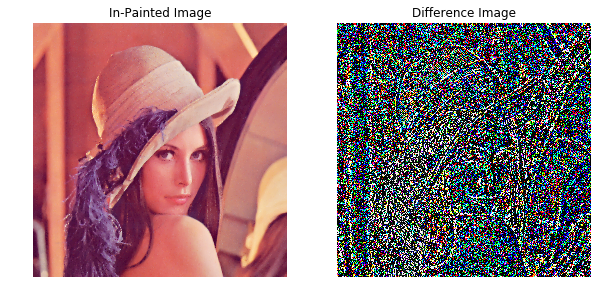

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Load variable values into a single array.
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');